Detektiranje tumora mozga

Importovi

In [2]:
import numpy as np
import cv2
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

Spajanje na drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


Učitavanje podataka

In [4]:
image_files = [os.path.join('/content/drive/MyDrive/Tumor', f) for f in os.listdir('/content/drive/MyDrive/Tumor') if os.path.isfile(os.path.join('/content/drive/MyDrive/Tumor', f))]
Tumor = []
for image_file in image_files:
    image = cv2.imread(image_file)
    if image is not None:
        Tumor.append(image)
    else:
        print(f"Failed to read image: {image_file}")
print(len(Tumor))

2000


In [5]:
image_files = [os.path.join('/content/drive/MyDrive/No_Tumor', f) for f in os.listdir('/content/drive/MyDrive/No_Tumor') if os.path.isfile(os.path.join('/content/drive/MyDrive/No_Tumor', f))]
No_Tumor = []
for image_file in image_files:
    image = cv2.imread(image_file)
    if image is not None:
        No_Tumor.append(image)
    else:
        print(f"Failed to read image: {image_file}")

print(len(No_Tumor))

2000


Nekolicina primjera podataka

Prisutan tumor

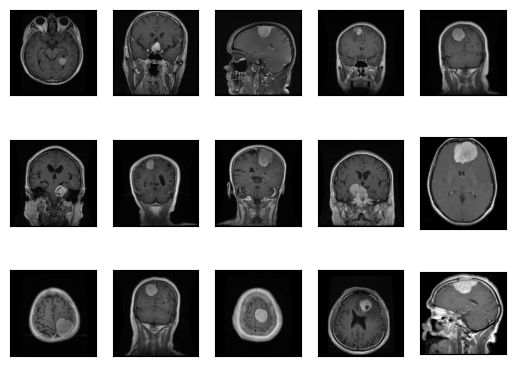

In [6]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(Tumor[i], cmap='bone')
    axi.set(xticks=[], yticks=[])

Neprisutan tumor

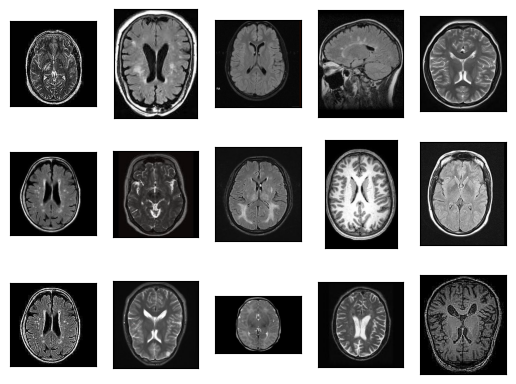

In [7]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(No_Tumor[i], cmap='bone')
    axi.set(xticks=[], yticks=[])

Procesiranje podataka

In [8]:
def resize_images(images, new_size):
  resized_images=[]
  for image in images:
    resized_image = cv2.resize(image, new_size)
    resized_images.append(resized_image)
  return resized_images
new_size = (224,224)
resized_images_tumor = resize_images(Tumor, new_size)
resized_images_no_tumor = resize_images(No_Tumor, new_size)

Prikaz slika sa novim dimenzijama

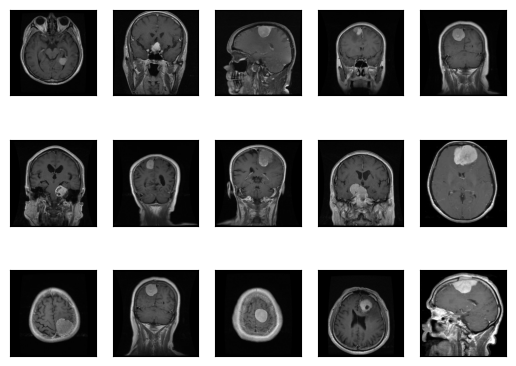

In [9]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(resized_images_tumor[i], cmap='bone')
    axi.set(xticks=[], yticks=[])

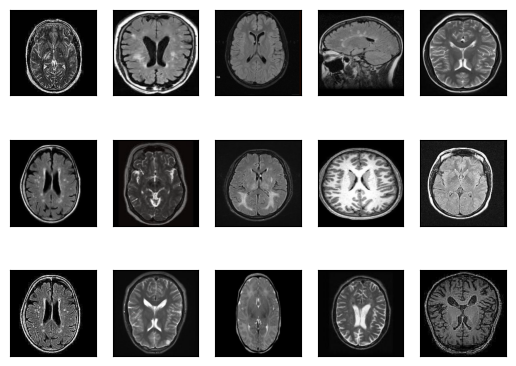

In [10]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(resized_images_no_tumor[i], cmap='bone')
    axi.set(xticks=[], yticks=[])

Croppanje mozga sa slika

In [11]:
def crop_imgs(set_name, add_pixels_value=0):
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])
        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(new_img, (224, 224))
        set_new.append(new_img)

    return np.stack(set_new)

In [12]:
crop_img_tumor = crop_imgs(resized_images_tumor)

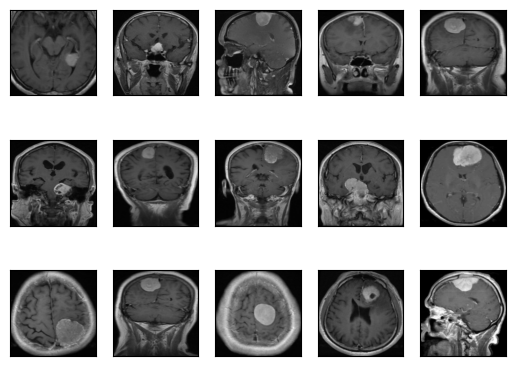

In [13]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(crop_img_tumor[i], cmap='bone')
    axi.set(xticks=[], yticks=[])

In [14]:
crop_img_no_tumor = crop_imgs(resized_images_no_tumor)

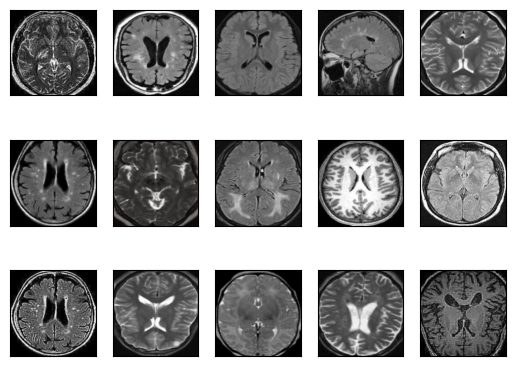

In [15]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(crop_img_no_tumor[i], cmap='bone')
    axi.set(xticks=[], yticks=[])

Dijeljenje podataka

In [16]:
data = np.concatenate((crop_img_tumor, crop_img_no_tumor))
labels = np.concatenate((np.ones(len(crop_img_tumor)), np.zeros(len(crop_img_no_tumor))))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

Arhitektura modela

In [18]:
from keras.applications import VGG16
IMG_SIZE = (224, 224)
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

58889256/58889256 [==============================] - 4s 0us/step


In [19]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [21]:
epohe = 30

model.fit(X_train, y_train, epochs=epohe, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
100/100 [==============================] - 29s 175ms/step - loss: 1.3322 - accuracy: 0.9178 - val_loss: 0.2982 - val_accuracy: 0.9700
Epoch 2/30
100/100 [==============================] - 17s 168ms/step - loss: 0.4313 - accuracy: 0.9694 - val_loss: 0.3354 - val_accuracy: 0.9725
Epoch 3/30
100/100 [==============================] - 15s 149ms/step - loss: 0.2769 - accuracy: 0.9781 - val_loss: 0.3722 - val_accuracy: 0.9825
Epoch 4/30
100/100 [==============================] - 15s 152ms/step - loss: 0.1915 - accuracy: 0.9841 - val_loss: 0.5306 - val_accuracy: 0.9688
Epoch 5/30
100/100 [==============================] - 17s 173ms/step - loss: 0.1673 - accuracy: 0.9872 - val_loss: 0.2113 - val_accuracy: 0.9862
Epoch 6/30
100/100 [==============================] - 15s 154ms/step - loss: 0.1194 - accuracy: 0.9906 - val_loss: 0.4008 - val_accuracy: 0.9800
Epoch 7/30
100/100 [==============================] - 15s 155ms/step - loss: 0.0800 - accuracy: 0.9934 - val_loss: 0.2833 - val_ac

In [22]:
y_pred = model.predict(X_test)

25/25 [==============================] - 3s 123ms/step


In [23]:
y_pred_flat = np.squeeze(y_pred)
y_pred_binary = (y_pred_flat > 0.5).astype(int)
accuracy_test = accuracy_score(y_test, y_pred_binary)
accuracy_test

0.98625